## This Notebook runs the Bernstein-Vazirani Algorithm ##

In [1]:
import random
import math
import numpy as np

import copy


import sys, os, time

from qinfer import LiuWestResampler
from qinfer import utils

from qiskit import IBMQ, Aer
from qiskit import QuantumCircuit, execute, Aer, QuantumCircuit
import qiskit.ignis.verification.randomized_benchmarking as rb
import matplotlib.lines as mlines

IBMQ.load_account()
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

Failed to import duecredit due to No module named 'duecredit'
/home/alan/aur/miniconda3/lib/python3.8/site-packages/IPython/parallel.py:12: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  warn("The `IPython.parallel` package has been deprecated since IPython 4.0. "
/home/alan/aur/miniconda3/lib/python3.8/site-packages/qinfer/parallel.py:61: UserWarning: Could not import IPython parallel. Parallelization support will be disabled.
  warnings.warn(
/home/alan/aur/miniconda3/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [2]:
import matplotlib.pyplot as plt
import seaborn as sbs

import smc_linear as smc
Distribution = smc.Distribution

sbs.set(style="darkgrid")

%matplotlib inline

In [3]:
def design_circuit(n_qubits, inv_arr, circuit=None):
    
    if circuit is None:
        circuit = QuantumCircuit(n_qubits, n_qubits)
    
    for i, element in enumerate(inv_arr):
        if element == 1:
            circuit.x(i)
    
    circuit.measure(list(range(n_qubits)), list(range(n_qubits)))
    return circuit

The below function constructs a BV circuit given a particular string and number of qubits

In [4]:
def bv_circuit(bv_string, n_qubits):
    '''
    bv_circuit
    Constructs a circuit that implements the Bernstein-Vazirani algorithm
    The string parameter dictates the expected state
    '''
        bv_circuit = QuantumCircuit(n_qubits, n_qubits - 1)
        
        for i in range(n_qubits):
            bv_circuit.h(i)
            
        bv_circuit.z(n_qubits - 1)
        
        bv_circuit.barrier()
        
        for i in range(n_qubits -1):
            if bv_string[i] == '1':
                bv_circuit.cx(i, n_qubits - 1)
        
        
        bv_circuit.barrier()
        
        for i in range(n_qubits - 1):
            bv_circuit.h(i)
        
        return bv_circuit

In [5]:
q = bv_circuit(str(1001), 5)
q.draw()

┌───┐      ░            ░ ┌───┐
q_0: ┤ H ├──────░───■────────░─┤ H ├
     ├───┤      ░   │        ░ ├───┤
q_1: ┤ H ├──────░───┼────────░─┤ H ├
     ├───┤      ░   │        ░ ├───┤
q_2: ┤ H ├──────░───┼────────░─┤ H ├
     ├───┤      ░   │        ░ ├───┤
q_3: ┤ H ├──────░───┼────■───░─┤ H ├
     ├───┤┌───┐ ░ ┌─┴─┐┌─┴─┐ ░ └───┘
q_4: ┤ H ├┤ Z ├─░─┤ X ├┤ X ├─░──────
     └───┘└───┘ ░ └───┘└───┘ ░      
c: 4/═══════════════════════════════

In [7]:
n_qubits = 4
circuit = bv_circuit(str(1001), 5)

In [8]:
provider = IBMQ.get_provider(group='open', project='main')
backend = provider.get_backend('ibmq_quito') # ibmq_vigo

n_measurements = 40
n_experiments = 20
n_points = 4000

results = []

for i in range(n_experiments):    

    result_data = {}
    
    

    result_data['circuit'] = circuit
    result_data['risk'] = []
    result_data['mean'] = []
    result_data['len'] = len(circuit)
    
    dist = Distribution(n_points=n_points, n_qubits=n_qubits)


    for _ in range(n_measurements):
        
        inversion_arr = dist.next_experiment()       
        
        tmp_circuit = copy.deepcopy(circuit)
        tmp_circuit = design_circuit(n_qubits, inversion_arr, circuit=tmp_circuit)

        
        job = execute(tmp_circuit, backend, shots=1)
        
        result = job.result()
        outcome = list(map(int, list(list(result.get_counts(circuit).keys())[0])))     
        
        print("Measurements: {} Outcome: {}".format(inversion_arr, outcome))
        dist.measure(outcome, inversion_arr)
        
        result_data['risk'].append(dist.calc_bayes_risk())
        result_data['mean'].append(dist.calc_bayes_mean())

    
    result_data['distrubtion'] = dist
    results.append(result_data)

Measurements: [0, 0, 0, 1] Outcome: [0, 0, 0, 0]
Measurements: [1, 0, 0, 0] Outcome: [0, 0, 0, 0]
Measurements: [0, 0, 0, 1] Outcome: [0, 0, 0, 1]
Measurements: [0, 1, 0, 0] Outcome: [1, 1, 1, 1]
Measurements: [0, 0, 0, 1] Outcome: [0, 0, 0, 0]
Measurements: [0, 0, 0, 1] Outcome: [0, 0, 0, 1]
Measurements: [0, 0, 1, 0] Outcome: [1, 0, 0, 1]
Measurements: [0, 1, 0, 0] Outcome: [1, 0, 1, 1]
Measurements: [0, 1, 0, 0] Outcome: [1, 0, 1, 1]
Measurements: [0, 1, 0, 0] Outcome: [1, 0, 1, 1]
Measurements: [0, 1, 0, 0] Outcome: [0, 0, 0, 1]
Measurements: [0, 1, 0, 0] Outcome: [1, 0, 1, 1]
Measurements: [0, 1, 0, 0] Outcome: [0, 0, 1, 1]
Measurements: [0, 1, 0, 0] Outcome: [0, 0, 1, 1]
Measurements: [0, 1, 0, 0] Outcome: [1, 0, 1, 1]
Measurements: [0, 1, 0, 0] Outcome: [1, 0, 1, 0]
Measurements: [0, 1, 0, 0] Outcome: [1, 0, 1, 1]
Measurements: [0, 1, 0, 0] Outcome: [1, 0, 0, 1]
Measurements: [0, 1, 0, 0] Outcome: [0, 0, 1, 1]
Measurements: [0, 1, 0, 0] Outcome: [1, 0, 1, 1]
Measurements: [0, 1,

Measurements: [0, 1, 0, 0] Outcome: [0, 0, 1, 1]
Measurements: [0, 1, 0, 0] Outcome: [1, 0, 1, 1]
Measurements: [0, 0, 1, 0] Outcome: [1, 1, 0, 1]
Measurements: [0, 0, 1, 0] Outcome: [1, 0, 0, 1]
Measurements: [1, 0, 0, 0] Outcome: [0, 0, 0, 0]
Measurements: [0, 0, 0, 1] Outcome: [0, 0, 1, 1]
Measurements: [0, 1, 0, 0] Outcome: [1, 0, 1, 1]
Measurements: [1, 0, 0, 0] Outcome: [1, 0, 0, 0]
Measurements: [0, 1, 0, 0] Outcome: [1, 1, 1, 1]
Measurements: [0, 0, 0, 1] Outcome: [0, 0, 0, 1]
Measurements: [0, 0, 0, 1] Outcome: [0, 0, 0, 0]
Measurements: [0, 0, 0, 1] Outcome: [0, 0, 0, 1]
Measurements: [0, 0, 0, 1] Outcome: [0, 0, 0, 1]
Measurements: [0, 0, 0, 1] Outcome: [0, 0, 0, 0]
Measurements: [0, 0, 0, 1] Outcome: [0, 0, 0, 1]
Measurements: [0, 1, 0, 0] Outcome: [1, 0, 1, 1]
Measurements: [0, 1, 0, 0] Outcome: [1, 0, 1, 1]
Measurements: [0, 1, 0, 0] Outcome: [1, 0, 1, 1]
Measurements: [0, 1, 0, 0] Outcome: [1, 0, 1, 1]
Measurements: [0, 1, 0, 0] Outcome: [0, 1, 1, 1]
Measurements: [1, 0,

Measurements: [0, 0, 1, 0] Outcome: [1, 1, 0, 1]
Measurements: [1, 0, 0, 0] Outcome: [1, 0, 0, 0]
Measurements: [0, 0, 1, 0] Outcome: [1, 1, 0, 1]
Measurements: [0, 0, 1, 0] Outcome: [1, 0, 0, 1]
Measurements: [0, 0, 1, 0] Outcome: [0, 1, 0, 1]
Measurements: [0, 0, 1, 0] Outcome: [1, 1, 0, 0]
Measurements: [0, 0, 1, 0] Outcome: [1, 1, 0, 1]
Measurements: [0, 0, 1, 0] Outcome: [1, 1, 0, 1]
Measurements: [0, 0, 1, 0] Outcome: [0, 0, 0, 1]
Measurements: [0, 0, 1, 0] Outcome: [1, 1, 0, 1]
Measurements: [0, 0, 1, 0] Outcome: [1, 1, 0, 1]
Measurements: [0, 0, 1, 0] Outcome: [1, 1, 0, 1]
Measurements: [1, 0, 0, 0] Outcome: [1, 0, 0, 0]
Measurements: [0, 0, 1, 0] Outcome: [0, 1, 0, 1]
Measurements: [0, 1, 0, 0] Outcome: [1, 0, 1, 0]
Measurements: [0, 0, 1, 0] Outcome: [1, 1, 0, 1]
Measurements: [0, 0, 1, 0] Outcome: [1, 0, 0, 1]
Measurements: [0, 1, 0, 0] Outcome: [1, 0, 1, 1]
Measurements: [1, 0, 0, 0] Outcome: [1, 0, 0, 0]
Measurements: [0, 1, 0, 0] Outcome: [0, 0, 1, 1]
Measurements: [0, 1,

Measurements: [0, 0, 1, 0] Outcome: [1, 1, 0, 1]
Measurements: [0, 0, 1, 0] Outcome: [1, 1, 0, 1]
Measurements: [0, 1, 0, 0] Outcome: [1, 0, 1, 1]
Measurements: [0, 0, 0, 1] Outcome: [0, 0, 0, 1]
Measurements: [0, 0, 0, 1] Outcome: [0, 0, 0, 1]
Measurements: [0, 1, 0, 0] Outcome: [1, 0, 1, 1]
Measurements: [1, 0, 0, 0] Outcome: [1, 0, 0, 0]
Measurements: [1, 0, 0, 0] Outcome: [1, 0, 0, 0]
Measurements: [0, 1, 0, 0] Outcome: [0, 0, 1, 1]
Measurements: [1, 0, 0, 0] Outcome: [1, 0, 0, 0]
Measurements: [0, 1, 0, 0] Outcome: [1, 0, 1, 0]
Measurements: [1, 0, 0, 0] Outcome: [1, 0, 0, 1]
Measurements: [0, 1, 0, 0] Outcome: [1, 0, 1, 1]
Measurements: [1, 0, 0, 0] Outcome: [1, 0, 0, 0]
Measurements: [0, 1, 0, 0] Outcome: [1, 0, 1, 1]
Measurements: [1, 0, 0, 0] Outcome: [1, 0, 0, 0]
Measurements: [0, 1, 0, 0] Outcome: [1, 0, 1, 1]
Measurements: [1, 0, 0, 0] Outcome: [1, 0, 0, 0]
Measurements: [0, 1, 0, 0] Outcome: [1, 0, 1, 1]
Measurements: [1, 0, 0, 0] Outcome: [1, 0, 0, 0]
Measurements: [0, 0,

Measurements: [0, 0, 0, 1] Outcome: [0, 0, 0, 1]
Measurements: [0, 0, 0, 1] Outcome: [0, 0, 0, 1]
Measurements: [0, 0, 0, 1] Outcome: [0, 0, 0, 1]
Measurements: [0, 0, 0, 1] Outcome: [0, 0, 0, 1]
Measurements: [0, 0, 0, 1] Outcome: [0, 0, 1, 1]
Measurements: [0, 0, 0, 1] Outcome: [0, 0, 0, 1]
Measurements: [0, 0, 0, 1] Outcome: [0, 0, 0, 1]
Measurements: [0, 0, 0, 1] Outcome: [0, 0, 0, 1]
Measurements: [1, 0, 0, 0] Outcome: [1, 0, 0, 0]
Measurements: [0, 1, 0, 0] Outcome: [0, 1, 1, 1]
Measurements: [1, 0, 0, 0] Outcome: [0, 0, 0, 1]
Measurements: [0, 0, 1, 0] Outcome: [1, 1, 0, 1]
Measurements: [0, 0, 1, 0] Outcome: [1, 1, 0, 1]
Measurements: [1, 0, 0, 0] Outcome: [1, 0, 0, 0]
Measurements: [0, 0, 1, 0] Outcome: [1, 1, 0, 1]
Measurements: [0, 0, 1, 0] Outcome: [1, 1, 0, 1]
Measurements: [0, 0, 0, 1] Outcome: [0, 1, 0, 1]
Measurements: [0, 0, 1, 0] Outcome: [1, 1, 1, 0]
Measurements: [0, 0, 0, 1] Outcome: [0, 0, 0, 1]
Measurements: [0, 0, 1, 0] Outcome: [1, 1, 0, 1]
Measurements: [0, 0,

In [40]:
provider = IBMQ.get_provider(group='open', project='main')
backend = provider.get_backend('ibmq_quito') # ibmq_vigo

for i, result in enumerate(results):
    
    
    tmp_circuit = copy.deepcopy(result['circuit'])
    inv_arr = np.zeros(n_qubits, dtype=int)
    
    tmp_circuit = design_circuit(n_qubits, inv_arr, circuit=tmp_circuit)
    job = execute(tmp_circuit, backend, shots=1024)
    ibm_result = job.result()
    
    results[i]['initial'] = ibm_result
    
    inv_arr = result['distrubtion'].next_experiment()
    
    tmp_circuit = copy.deepcopy(result['circuit'])
    tmp_circuit = design_circuit(n_qubits, inv_arr, circuit=tmp_circuit)
    job = execute(tmp_circuit, backend, shots=1024)
    ibm_result = job.result() 
    
    results[i]['final'] = ibm_result
    
    print(i)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


And here we plot our initial and final counts

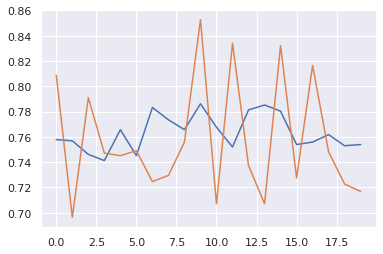

In [96]:
plt.plot([max(i['initial'].get_counts().values()) / 1024 for i in results])) 
plt.plot([max(i['final'].get_counts().values()) / 1024 for i in results])

In [99]:
print(max([max(i['initial'].get_counts().values()) / 1024 for i in results]))
print(max([max(i['final'].get_counts().values()) / 1024 for i in results]))

0.7861328125
0.8525390625


In [108]:
init = max([max(i['initial'].get_counts().values()) / 1024 for i in results])
final = max([max(i['final'].get_counts().values()) / 1024 for i in results])

((final - init) / init + 1) * init


0.8525390624999999

In [80]:
print(print(results[17]['final'].get_counts()))
print(inv_arr)

{'0001': 7, '0100': 13, '0101': 83, '0110': 1, '0111': 6, '1000': 4, '1001': 35, '1011': 2, '1100': 80, '1101': 766, '1110': 7, '1111': 20}
None
[0, 1, 0, 0]


In [31]:
test_res = results[i]['final'].get_counts()

In [33]:
max(test_res.values())

180

In [38]:
results[i - 1]['circuit'].draw()

┌───┐      ░            ░ ┌───┐
q_0: ┤ H ├──────░───■────────░─┤ H ├
     ├───┤      ░   │        ░ ├───┤
q_1: ┤ H ├──────░───┼────────░─┤ H ├
     ├───┤      ░   │        ░ ├───┤
q_2: ┤ H ├──────░───┼────────░─┤ H ├
     ├───┤      ░   │        ░ ├───┤
q_3: ┤ H ├──────░───┼────■───░─┤ H ├
     ├───┤┌───┐ ░ ┌─┴─┐┌─┴─┐ ░ └───┘
q_4: ┤ H ├┤ Z ├─░─┤ X ├┤ X ├─░──────
     └───┘└───┘ ░ └───┘└───┘ ░      
c: 4/═══════════════════════════════